In [11]:
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Dropout
import numpy as np

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
zip_path = ("/content/drive/MyDrive/Dataset for DR.zip")


In [14]:
unzip_dir = ("/content/dataset")

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)
dataset_path = unzip_dir

In [15]:
train_data_gen = ImageDataGenerator(
   rescale=1.0 / 255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"        # Reserve 20% of data for validation
)

# Create the training data generator with augmentation
train_data = train_data_gen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),      # Resize images to 224x224
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    subset='training'           # Training subset
)

# Validation generator (no augmentation, just normalization)
val_data_gen = ImageDataGenerator(
    rescale=1.0/255,            # Normalize pixel values
    validation_split=0.2        # Use the same split as above
)

val_data = val_data_gen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'         # Validation subset
)


Found 757 images belonging to 7 classes.
Found 148 images belonging to 7 classes.


In [16]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Unfreeze top layers of MobileNetV2 for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Keep most layers frozen
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce dimensions of feature maps
x = Dropout(0.4)(x)  # Dropout rate of 40%
x = Dense(128, activation='relu')(x)  # Fully connected layer
output = Dense(7, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

clr = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))  # Gradually increase LR

# Show a summary of the model
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 1,691,271 (6.45 MB)

 Non-trainable params: 731,584 (2.79 MB)

In [17]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights = dict(enumerate(class_weights))
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=5,           # Number of epochs with no improvement before reducing LR
    min_lr=1e-6          # Minimum learning rate
)

In [18]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max'
)



In [19]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[lr_callback],
    class_weight=class_weights
)
# Save the trained model
model.save('/content/drive/MyDrive/diabetic_retinopathy_model.h5')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 121s 3s/step - accuracy: 0.2328 - loss: 2.0603 - val_accuracy: 0.3243 - val_loss: 2.1560 - learning_rate: 1.0000e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 3s/step - accuracy: 0.4513 - loss: 1.6931 - val_accuracy: 0.4189 - val_loss: 1.9382 - learning_rate: 1.0000e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.5171 - loss: 1.3621 - val_accuracy: 0.4459 - val_loss: 1.8951 - learning_rate: 1.0000e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.5808 - loss: 1.2618 - val_accuracy: 0.4257 - val_loss: 1.7719 - learning_rate: 1.0000e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.5995 - loss: 1.1233 - val_accuracy: 0.4459 - val_loss: 1.7078 - learning_rate: 1.0000e-04
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.6400 - loss: 1.0597 - val_accuracy: 0.4459 - val_loss: 1.6289 - learning_rate: 1.0000e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.6683 - loss: 0.9879

In [20]:
# Evaluate the model on validation data
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.9626 - loss: 0.2338
Validation Accuracy: 95.95%
Validation Loss: 0.2543


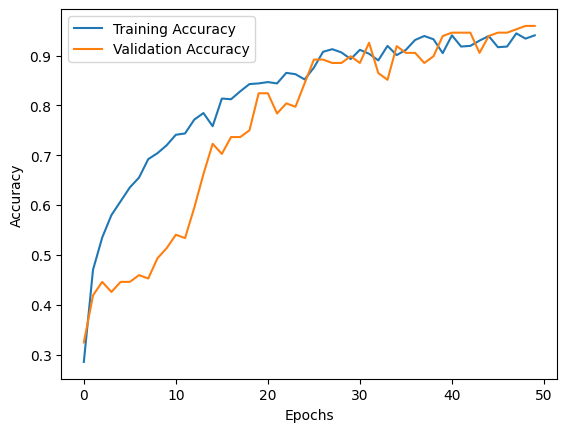

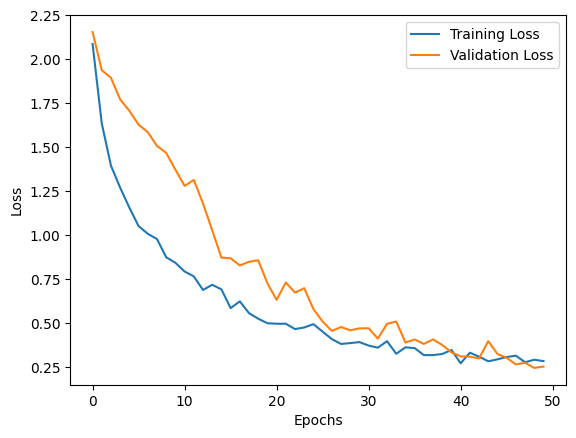

In [21]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

